import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

read data and metadata

In [2]:
datafile_train="../data/raw_data/train.csv"
datafile_test=r"../data/raw_data/test_share.csv"
bd_train=pd.read_csv(datafile_train)
bd_test=pd.read_csv(datafile_test)

medical_hist='../data/raw_data/medical_history.csv'
demo_det='../data/raw_data/demographic_details.csv'
med=pd.read_csv(medical_hist)
dem=pd.read_csv(demo_det)

Combining metedata. both the datasets have patient id as unique identifier 

In [3]:
comb=pd.merge(med,dem,how='outer',on='PatientId')
#comb.head()

combining training data and metadata

In [4]:
train=pd.merge(bd_train,comb,how='left',on='PatientId')
test=pd.merge(bd_test,comb,how='left',on='PatientId')

### Data processing

In [5]:
# drop PatientId', 'AppointmentID'

drop_cols=['PatientId', 'AppointmentID']
train.drop(drop_cols,1,inplace=True)
test.drop(drop_cols,1,inplace=True)

Combining train and test dataset for simultaneous preprocessing to the new dataset "all_data"


In [6]:
train['data']='train'
test['data']='test'

all_data=pd.concat([train,test],0,sort=False)

In [7]:
# modifying dtype to datetime

# all_data.ScheduledDay.dtype
all_data.ScheduledDay = pd.to_datetime(all_data.ScheduledDay)
all_data.AppointmentDay = pd.to_datetime(all_data.AppointmentDay)


check if the "dayOfWeek" contributes to the target


Correlation coefficient between dayOfWeek & target:
 [[1.00000000e+00 9.87963717e-04]
 [9.87963717e-04 1.00000000e+00]]


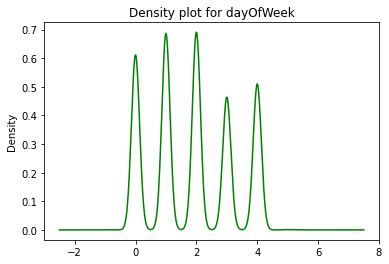

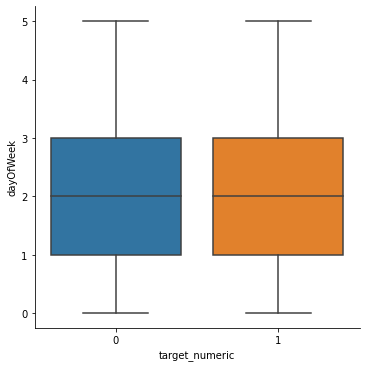

In [8]:
# converting target variable to numeric
all_data['target_numeric'] = np.where(all_data['No-show']=="No", 0, 1)
all_data['target_numeric'].astype('int')

# extracting dayOfWeek and hour column 

#all_data['dayOfWeek'] = all_data['AppointmentDay'].dt.day_name()
all_data['dayOfWeek'] = all_data['AppointmentDay'].dt.dayofweek 
all_data['dayOfWeek'].dtype

# calculate corr coefficient between target and dayOfWeek
corr = (np.corrcoef(all_data['dayOfWeek'], all_data['target_numeric']))
print("Correlation coefficient between dayOfWeek & target:\n" , corr)

# Density plot for dayOfWeek

all_data.dayOfWeek.plot.density(color='green')
plt.title('Density plot for dayOfWeek')
plt.show()

sns.catplot(x="target_numeric", y="dayOfWeek",  kind="box", data=all_data)

check if the "diff_bookingDays" contributes to the target


Correlation coefficient between diff_bookingDays & target:
 [[1.         0.14319452]
 [0.14319452 1.        ]]


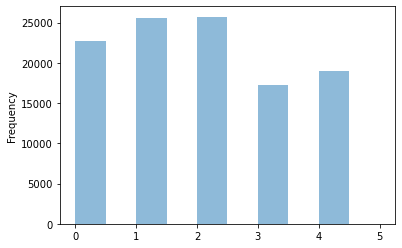

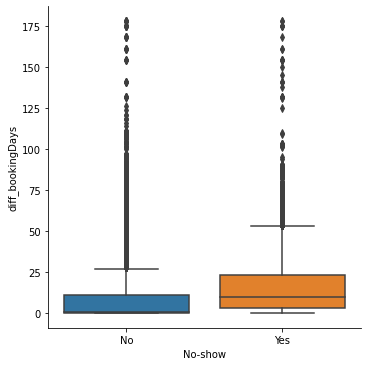

In [9]:
# calculating difference in sucheduled day from the appointment day

all_data['diff_bookingDays'] = (all_data['AppointmentDay']-all_data['ScheduledDay']).astype('timedelta64[D]')
all_data['diff_bookingDays'].head()
all_data['diff_bookingDays'] = np.where(all_data['diff_bookingDays']< 0, 0, all_data['diff_bookingDays'])
all_data.head()
all_data['diff_bookingDays'].astype('int')

# calculate corr coefficient between target and diff_bookingDays
corr = (np.corrcoef(all_data['diff_bookingDays'], all_data['target_numeric']))
print("Correlation coefficient between diff_bookingDays & target:\n" , corr)

# # boxplot dayOfWeek vs target_numeric
# sns.boxplot(x="diff_bookingDays", y="target_numeric",data= all_data)

all_data['dayOfWeek'].plot.hist(alpha=0.5)

sns.catplot(x="No-show", y="diff_bookingDays",  kind="box", data=all_data)

In [10]:
drop_cols=['AppointmentDay', 'ScheduledDay', 'No-show']
all_data.drop(drop_cols,1,inplace=True)

In [11]:
# mutate Gender
all_data['gender_f']=(all_data['Gender']=='F').astype(int)
del all_data['Gender']

# create dummies for Neighbourhood with cutoff

k=all_data['Neighbourhood'].value_counts()
cats=k[k>2000].index

for cat in cats:
    name='Neighbourhood_'+cat
    all_data[name]=(all_data['Neighbourhood']==cat).astype(int)
del all_data['Neighbourhood']

Preparing dataset for training 


In [12]:
target='target_numeric'
train_data = all_data[all_data['data']=='train']

# splitting back the train and test datasets
X = train_data.drop([target,'data'],1)
y = train_data[target]
x_test = all_data.drop([target,'data'],1)[all_data['data']=='test']

# Divide the training data given to train and validation data frames
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Saving processed data

In [14]:
x_train.to_csv('../data/processed_data/x_train.csv',index=False)
x_val.to_csv('../data/processed_data/x_val.csv',index=False)
y_train.to_csv('../data/processed_data/y_train.csv',index=False)
y_val.to_csv('../data/processed_data/y_val.csv',index=False)
x_test.to_csv('../data/processed_data/x_test.csv',index=False)